In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, datasets
import json
import torchvision.models as models
from imagenetv2_pytorch import ImageNetV2Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchattacks
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Custom Dataset Wrapper
class PreprocessedImageNetV2(torch.utils.data.Dataset):
    def __init__(self, variant="matched-frequency"):
        self.dataset = ImageNetV2Dataset(variant)
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225]),
        ])
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return self.preprocess(img), label

In [5]:
# Load model and dataset
model = models.resnet18().to(device).eval()
model.load_state_dict(torch.load('resnet18_finetuned_pgd.pth'))
dataset = PreprocessedImageNetV2("matched-frequency")
dataloader = DataLoader(dataset, batch_size=32, num_workers=4)

In [6]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)
    
    def save_activations(self, module, input, output):
        self.activations = output
    
    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def __call__(self, x, class_idx=None):
        # Forward pass
        output = self.model(x)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        
        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Grad-CAM calculation
        weights = F.adaptive_avg_pool2d(self.gradients, 1)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, x.shape[2:], mode='bilinear', align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam.squeeze().cpu().detach()

In [7]:
# Get ImageNet class names
with open('imagenet_class_index.json') as f:
    class_idx = json.load(f)

imagenet_classes = [class_idx[i] for i in range(1000)]

In [8]:
# 1. Setup GradCAM
target_layer = model.layer4[-1]  # Last conv layer for ResNet18
gradcam = GradCAM(model, target_layer)

In [9]:
# 2. Get correctly classified samples
def get_correct_samples(model, dataloader, num_samples=1000):
    correct_images = []
    correct_labels = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            correct_mask = preds == labels
            correct_images.append(images[correct_mask])
            correct_labels.append(labels[correct_mask])
            
            if len(torch.cat(correct_images)) >= num_samples:
                break
    
    return (torch.cat(correct_images)[:num_samples], 
            torch.cat(correct_labels)[:num_samples])

#correct_images, correct_labels = get_correct_samples(model, dataloader)

In [10]:
# 3. Generate adversarial attacks on correct samples
pgd_attack = torchattacks.PGD(
    model,
    eps=4/255,       # Maximum perturbation (8 pixel intensity)
    alpha=2/255,     # Attack step size
    steps=10,        # Number of attack iterations
    random_start=True # Start from random point in epsilon ball
)
#adv_images = pgd_attack(correct_images.clone(), correct_labels.clone())

In [11]:
# 4. Get GradCAM visualizations
def get_gradcam_visuals(model, images, labels, gradcam):
    heatmaps = []
    for img, label in zip(images, labels):
        heatmap = gradcam(img.unsqueeze(0), label.unsqueeze(0))
        heatmaps.append(heatmap)
    return torch.stack(heatmaps)

#clean_heatmaps = get_gradcam_visuals(model, correct_images, correct_labels, gradcam)
#adv_heatmaps = get_gradcam_visuals(model, adv_images, correct_labels, gradcam)

In [12]:
# 5. Quantitative analysis

def calculate_entropy(heatmap):
    # Flatten the heatmap and compute entropy
    heatmap_flattened = heatmap.flatten(1)
    
    # Ensure no zero values in the heatmap for probability calculation
    heatmap_flattened = heatmap_flattened + 1e-8  # Add small epsilon to avoid log(0)

    # Normalize the heatmap to get the probability distribution
    prob_distribution = heatmap_flattened / heatmap_flattened.sum(dim=1, keepdim=True)
    
    # Ensure no values are zero after normalization
    prob_distribution = torch.clamp(prob_distribution, min=1e-8)
    
    # Compute entropy
    entropy = -torch.sum(prob_distribution * torch.log(prob_distribution + 1e-8), dim=1)
    
    # Return the mean entropy
    return entropy.mean().item()

def analyze_heatmap_changes(clean_heatmaps, adv_heatmaps):
    # Pixel-wise difference
    diffs = (clean_heatmaps - adv_heatmaps).abs().mean(dim=[1,2])
    
    # Attention shift metrics
    clean_max = clean_heatmaps.flatten(1).max(dim=1).indices
    adv_max = adv_heatmaps.flatten(1).max(dim=1).indices
    pos_shift = (clean_max != adv_max).float().mean()
    
    # Entropy calculation
    clean_entropy = calculate_entropy(clean_heatmaps)
    adv_entropy = calculate_entropy(adv_heatmaps)
    entropy_diff = adv_entropy - clean_entropy
    
    # Print results
    print(f"Mean absolute difference: {diffs.mean().item():.4f}")
    print(f"Attention position changed: {pos_shift.item()*100:.2f}% of cases")
    print(f"Clean Heatmap Entropy: {clean_entropy:.4f}")
    print(f"Adversarial Heatmap Entropy: {adv_entropy:.4f}")
    print(f"Entropy Difference: {entropy_diff:.4f}")

#analyze_heatmap_changes(clean_heatmaps, adv_heatmaps)

In [13]:
# 6. Visualization function
def plot_gradcam_comparison(clean_images, adv_images, 
                          clean_heatmaps, adv_heatmaps,
                          labels, class_names):
    plt.figure(figsize=(15, 10))
    num_samples = len(clean_images)
    print(len(clean_images))
    
    for i in range(num_samples):
        # Denormalize images
        denorm = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        
        # Clean image + GradCAM
        plt.subplot(2, num_samples, i+1)
        clean_img = denorm(clean_images[i]).cpu().permute(1, 2, 0).clamp(0, 1)
        plt.imshow(clean_img)
        plt.imshow(clean_heatmaps[i], alpha=0.5, cmap='jet')
        plt.title(f"Clean\n{class_names[labels[i].item()]}")
        plt.axis('off')
        
        # Adversarial image + GradCAM
        plt.subplot(2, num_samples, num_samples+i+1)
        adv_img = denorm(adv_images[i]).cpu().permute(1, 2, 0).clamp(0, 1)
        plt.imshow(adv_img)
        plt.imshow(adv_heatmaps[i], alpha=0.5, cmap='jet')

        with torch.no_grad():
            adv_outputs = model(adv_images[i].unsqueeze(0).to(device))
            _, adv_pred = torch.max(adv_outputs, 1)
        
        plt.title(f"Adversarial\n{class_names[adv_pred.item()]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 6. Run visualization
'''plot_gradcam_comparison(correct_images[:5], adv_images[:5],
                      clean_heatmaps, adv_heatmaps,
                      correct_labels, class_names=imagenet_classes)'''

'plot_gradcam_comparison(correct_images[:5], adv_images[:5],\n                      clean_heatmaps, adv_heatmaps,\n                      correct_labels, class_names=imagenet_classes)'

In [14]:
def perform_attack_and_analyze(model, dataloader, gradcam, attack_class, attack_params, num_samples=1000):
    """
    Performs an adversarial attack, computes Grad-CAM visualizations, 
    calculates entropy, and analyzes the changes between clean and adversarial heatmaps.
    
    Args:
    - model: The pretrained model.
    - dataloader: The dataloader containing the dataset.
    - gradcam: The GradCAM object used for generating heatmaps.
    - attack_class: The adversarial attack class (e.g., PGD).
    - attack_params: The parameters for the attack.
    - num_samples: The number of correctly classified samples to use.
    
    Returns:
    - None: Prints the analysis results for each attack.
    """
    # Get correctly classified samples
    correct_images, correct_labels = get_correct_samples(model, dataloader, num_samples)
    
    # Generate adversarial images using the given attack class and parameters
    attack = attack_class(model, **attack_params)
    adv_images = attack(correct_images.clone(), correct_labels.clone())
    
    # Get GradCAM visualizations for both clean and adversarial images
    clean_heatmaps = get_gradcam_visuals(model, correct_images, correct_labels, gradcam)
    adv_heatmaps = get_gradcam_visuals(model, adv_images, correct_labels, gradcam)
    
    # Perform the analysis and capture the metrics
    diffs = (clean_heatmaps - adv_heatmaps).abs().mean(dim=[1,2])
    clean_max = clean_heatmaps.flatten(1).max(dim=1).indices
    adv_max = adv_heatmaps.flatten(1).max(dim=1).indices
    pos_shift = (clean_max != adv_max).float().mean()
    
    clean_entropy = calculate_entropy(clean_heatmaps)
    adv_entropy = calculate_entropy(adv_heatmaps)
    entropy_diff = clean_entropy - adv_entropy
    
    # Store the results for plotting
    attack_results['epsilon'].append(attack_params['eps'])
    attack_results['adv_entropy'].append(adv_entropy)
    attack_results['entropy_diff'].append(entropy_diff)
    attack_results['attention_shift'].append(pos_shift.item())
    
    # Print the analysis
    print(f"Mean absolute difference: {diffs.mean().item():.4f}")
    print(f"Attention position changed: {pos_shift.item()*100:.2f}% of cases")
    print(f"Clean Heatmap Entropy: {clean_entropy:.4f}")
    print(f"Adversarial Heatmap Entropy: {adv_entropy:.4f}")
    print(f"Entropy Difference: {entropy_diff:.4f}")
    
def plot_attack_results(attack_results):
    epsilons = attack_results['epsilon']
    
    # Plot entropy
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, attack_results['adv_entropy'], label="Adversarial Entropy", marker='o')
    plt.xlabel('Epsilon (Perturbation Size)')
    plt.ylabel('Entropy')
    plt.title('Adversarial Image Entropy vs Epsilon')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot entropy difference
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, attack_results['entropy_diff'], label="Entropy Difference (Clean - Adversarial)", marker='o')
    plt.xlabel('Epsilon (Perturbation Size)')
    plt.ylabel('Entropy Difference')
    plt.title('Entropy Difference vs Epsilon')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot attention shift
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, attack_results['attention_shift'], label="Attention Shift", marker='o')
    plt.xlabel('Epsilon (Perturbation Size)')
    plt.ylabel('Attention Shift (%)')
    plt.title('Attention Shift vs Epsilon')
    plt.ylim(0.85, 1.0)
    plt.grid(True)
    plt.legend()
    plt.show()

Performing attack with parameters: {'eps': 0.00784313725490196, 'alpha': 0.00784313725490196, 'steps': 10, 'random_start': True}
Mean absolute difference: 0.1499
Attention position changed: 86.30% of cases
Clean Heatmap Entropy: 10.2962
Adversarial Heatmap Entropy: 10.4078
Entropy Difference: -0.1116

--------------------------------------------------

Performing attack with parameters: {'eps': 0.01568627450980392, 'alpha': 0.00784313725490196, 'steps': 10, 'random_start': True}
Mean absolute difference: 0.1571
Attention position changed: 89.15% of cases
Clean Heatmap Entropy: 10.2962
Adversarial Heatmap Entropy: 10.3581
Entropy Difference: -0.0619

--------------------------------------------------

Performing attack with parameters: {'eps': 0.023529411764705882, 'alpha': 0.00784313725490196, 'steps': 10, 'random_start': True}
Mean absolute difference: 0.1689
Attention position changed: 90.18% of cases
Clean Heatmap Entropy: 10.2962
Adversarial Heatmap Entropy: 10.2639
Entropy Differe

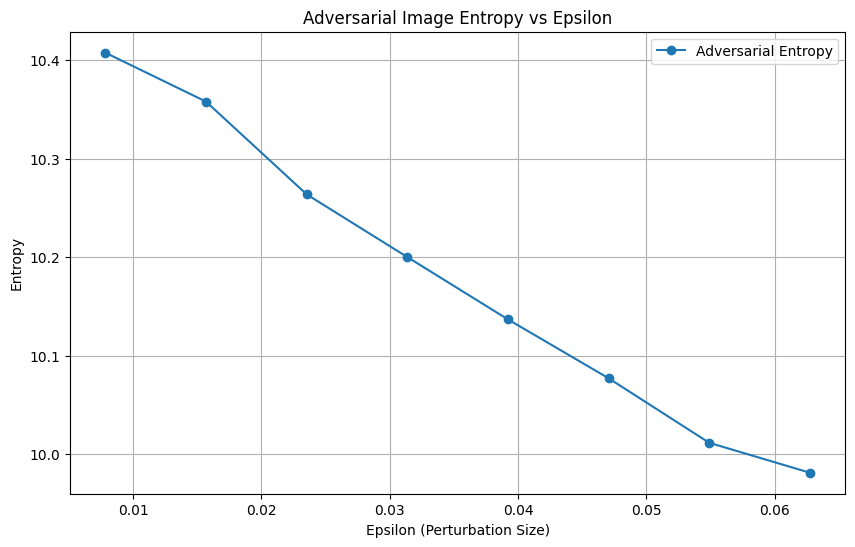

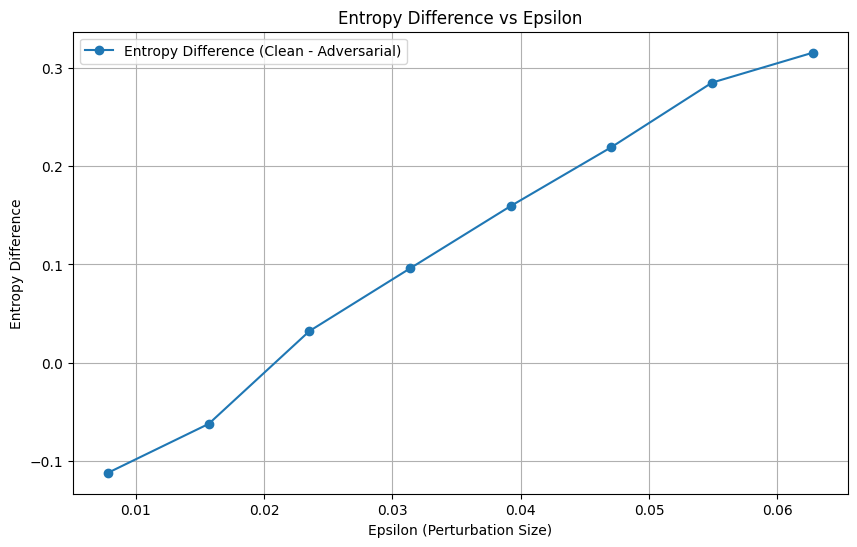

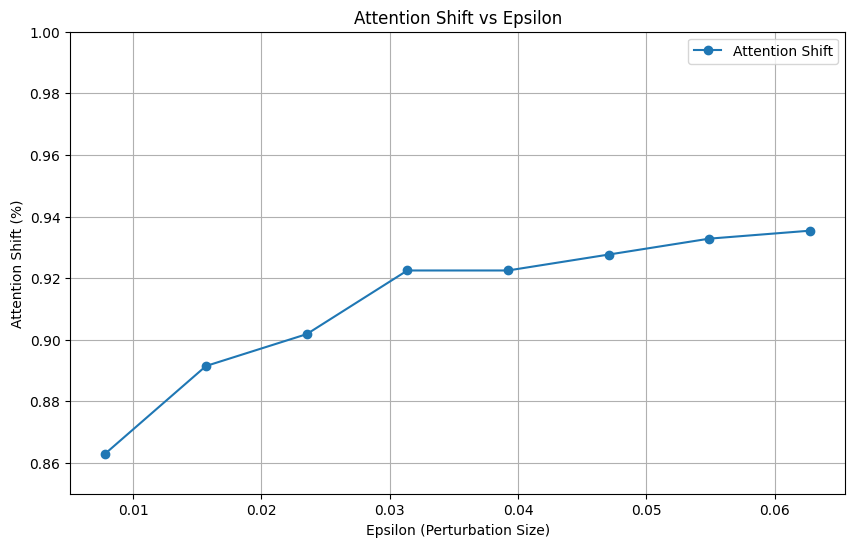

In [16]:
# Attacking with PGD

# Store results for plotting
attack_results = {
    'epsilon': [],
    'adv_entropy': [],
    'entropy_diff': [],
    'attention_shift': []
}

attack_params_list = [
    {'eps': 2/255, 'alpha': 2/255, 'steps': 10, 'random_start': True},
    {'eps': 4/255, 'alpha': 2/255, 'steps': 10, 'random_start': True},
    {'eps': 6/255, 'alpha': 2/255, 'steps': 10, 'random_start': True},
    {'eps': 8/255, 'alpha': 2/255, 'steps': 10, 'random_start': True},
    {'eps': 10/255, 'alpha': 2/255, 'steps': 10, 'random_start': True},
    {'eps': 12/255, 'alpha': 2/255, 'steps': 10, 'random_start': True},
    {'eps': 14/255, 'alpha': 2/255, 'steps': 10, 'random_start': True},
    {'eps': 16/255, 'alpha': 2/255, 'steps': 10, 'random_start': True}
]

# Loop through the different attack parameters
for attack_params in attack_params_list:
    print(f"Performing attack with parameters: {attack_params}")
    perform_attack_and_analyze(
        model, 
        dataloader, 
        gradcam, 
        torchattacks.PGD, 
        attack_params
    )
    print("\n" + "-"*50 + "\n")


# Plot the results
plot_attack_results(attack_results)


In [19]:
filename = 'attack_results/pgd_attack_results/attack_results_finetuned.json'

# Write dictionary to JSON file
with open(filename, 'w') as json_file:
    json.dump(attack_results, json_file, indent=4)

print(f"Dictionary saved to {filename}")

Dictionary saved to attack_results/pgd_attack_results/attack_results_finetuned.json


Performing attack with parameters: {'eps': 0.00784313725490196}


/home/hice1/pkutz3/.conda/envs/mls_assignment1/lib/python3.11/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Mean absolute difference: 0.1741
Attention position changed: 91.40% of cases
Clean Heatmap Entropy: 10.5576
Adversarial Heatmap Entropy: 10.4423
Entropy Difference: 0.1153

--------------------------------------------------

Performing attack with parameters: {'eps': 0.01568627450980392}
Mean absolute difference: 0.1772
Attention position changed: 91.40% of cases
Clean Heatmap Entropy: 10.5576
Adversarial Heatmap Entropy: 10.4322
Entropy Difference: 0.1255

--------------------------------------------------

Performing attack with parameters: {'eps': 0.023529411764705882}
Mean absolute difference: 0.1803
Attention position changed: 91.90% of cases
Clean Heatmap Entropy: 10.5576
Adversarial Heatmap Entropy: 10.4225
Entropy Difference: 0.1352

--------------------------------------------------

Performing attack with parameters: {'eps': 0.03137254901960784}
Mean absolute difference: 0.1831
Attention position changed: 92.10% of cases
Clean Heatmap Entropy: 10.5576
Adversarial Heatmap Entr

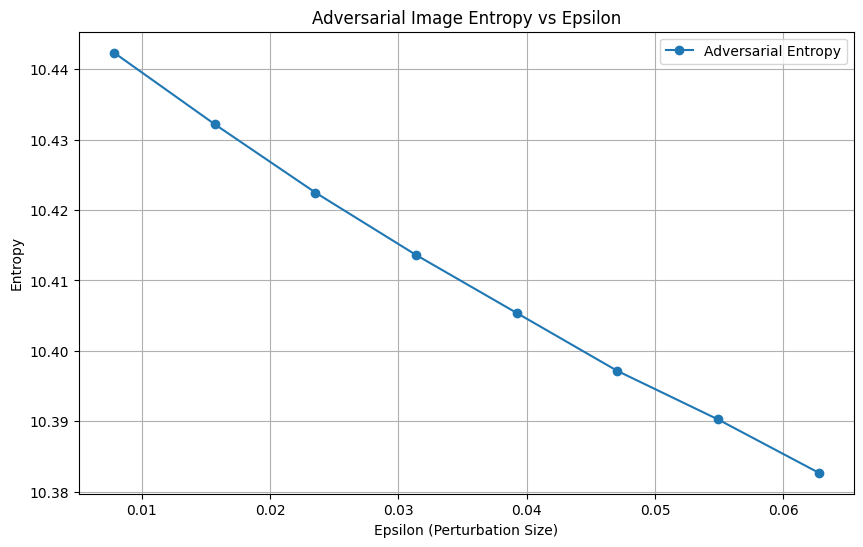

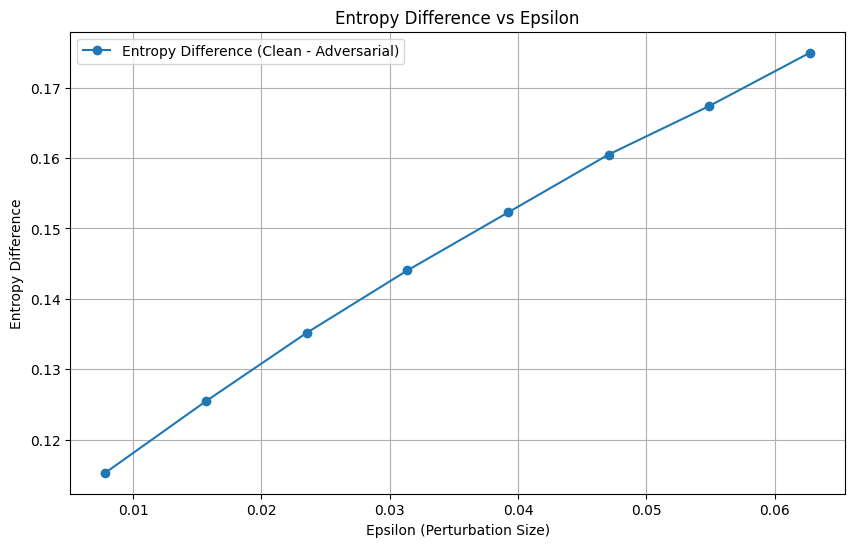

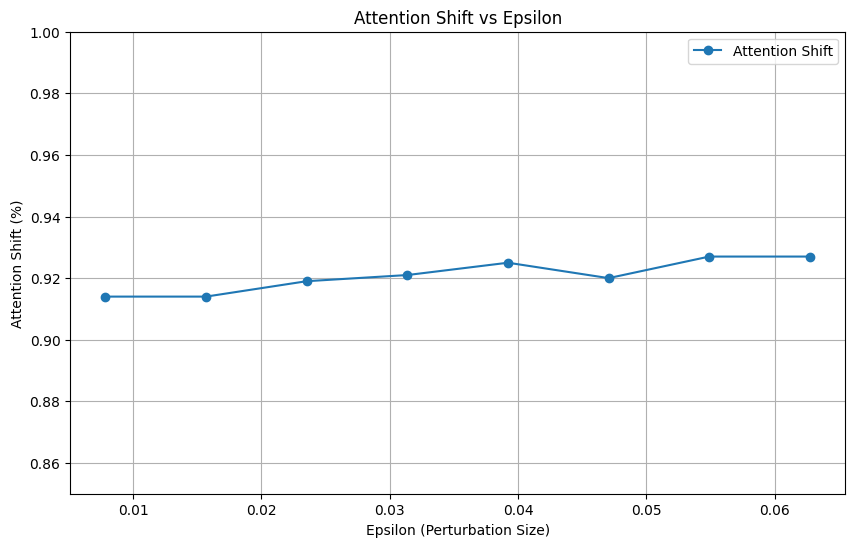

In [31]:
# Attacking with FGSM

# Store results for plotting
fgsm_attack_results = {
    'epsilon': [],
    'adv_entropy': [],
    'entropy_diff': [],
    'attention_shift': []
}

attack_params_list = [
    {'eps': 2/255},
    {'eps': 4/255},
    {'eps': 6/255},
    {'eps': 8/255},
    {'eps': 10/255},
    {'eps': 12/255},
    {'eps': 14/255},
    {'eps': 16/255}
]

# Loop through the different attack parameters
for attack_params in attack_params_list:
    print(f"Performing attack with parameters: {attack_params}")
    perform_attack_and_analyze(
        model, 
        dataloader, 
        gradcam, 
        torchattacks.FGSM, 
        attack_params
    )
    print("\n" + "-"*50 + "\n")

# Plot the results
plot_attack_results(attack_results)


In [32]:
filename = 'fgsm_attack_results/fgsm_attack_results.json'

# Write dictionary to JSON file
with open(filename, 'w') as json_file:
    json.dump(attack_results, json_file, indent=4)

print(f"Dictionary saved to {filename}")

Dictionary saved to fgsm_attack_results/fgsm_attack_results.json


In [20]:
'''# Attacking with DeepFool

# Store results for plotting
attack_results = {
    'epsilon': [],
    'adv_entropy': [],
    'entropy_diff': [],
    'attention_shift': []
}

attack_params_list = [
    {'steps': 10}
]

# Loop through the different attack parameters
for attack_params in attack_params_list:
    print(f"Performing attack with parameters: {attack_params}")
    perform_attack_and_analyze(
        model, 
        dataloader, 
        gradcam, 
        torchattacks.DeepFool, 
        attack_params
    )
    print("\n" + "-"*50 + "\n")

# Plot the results
plot_attack_results(attack_results)'''

'# Attacking with DeepFool\n\n# Store results for plotting\nattack_results = {\n    \'epsilon\': [],\n    \'adv_entropy\': [],\n    \'entropy_diff\': [],\n    \'attention_shift\': []\n}\n\nattack_params_list = [\n    {\'steps\': 10}\n]\n\n# Loop through the different attack parameters\nfor attack_params in attack_params_list:\n    print(f"Performing attack with parameters: {attack_params}")\n    perform_attack_and_analyze(\n        model, \n        dataloader, \n        gradcam, \n        torchattacks.DeepFool, \n        attack_params\n    )\n    print("\n" + "-"*50 + "\n")\n\n# Plot the results\nplot_attack_results(attack_results)'

In [ ]:
model = models.resnet18(pretrained=True).to(device).eval()
dataset = PreprocessedImageNetV2("matched-frequency")
dataloader = DataLoader(dataset, batch_size=32, num_workers=4)

# PGD Attack Parameters
attack_params = {
    'eps': 2/255,  # Maximum perturbation (8 pixel intensity)
    'alpha': 2/255,  # Attack step size
    'steps': 10,  # Number of attack iterations
    'random_start': True  # Start from random point in epsilon ball
}

# Step 1: Generate and save adversarial images
generate_adversarial_images(model, dataloader, torchattacks.PGD, attack_params, num_samples=2000, save_path="adv_images.pth")

In [34]:
# Function to generate adversarial images and store them
def generate_adversarial_images(model, dataloader, attack_class, attack_params, num_samples=5000, save_path="adv_images.pth"):
    """
    Generates adversarial examples from clean images and saves them to a specified path.

    Args:
    - model: The pretrained model.
    - dataloader: DataLoader with the dataset.
    - attack_class: The adversarial attack class (e.g., PGD).
    - attack_params: The parameters for the attack.
    - num_samples: The number of clean examples to use.
    - save_path: The path where the adversarial images will be saved.

    Returns:
    - None
    """
    model.eval()  # Set model to evaluation mode
    correct_images, correct_labels = get_correct_samples(model, dataloader, num_samples)

    # Generate adversarial examples using PGD attack
    attack = attack_class(model, **attack_params)
    adv_images = attack(correct_images.clone(), correct_labels.clone())

    # Save the adversarial images
    torch.save({
        'adv_images': adv_images,
        'correct_labels': correct_labels
    }, save_path)

    print(f"Adversarial images saved to {save_path}")

# Function to load the adversarial images
def load_adversarial_images(file_path="adv_images.pth"):
    """
    Loads the adversarial images and their corresponding labels.

    Args:
    - file_path: The path to the saved adversarial images.

    Returns:
    - adv_images: The adversarial images.
    - correct_labels: The corresponding labels for the clean images.
    """
    checkpoint = torch.load(file_path)
    adv_images = checkpoint['adv_images']
    correct_labels = checkpoint['correct_labels']
    return adv_images, correct_labels


In [36]:
import torch.optim as optim

def adversarial_finetune(model, adv_images, correct_labels, num_epochs=5, lr=0.0001, batch_size=32):
    """
    Fine-tunes the model using only pre-generated adversarial examples.

    Args:
    - model: The pre-trained model.
    - adv_images: The adversarial images.
    - correct_labels: The corresponding labels for the adversarial images.
    - num_epochs: Number of epochs to train.
    - lr: Learning rate for fine-tuning.
    - batch_size: The batch size used for training.

    Returns:
    - model: The fine-tuned model.
    """
    model.train()  # Set model to training mode

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # Number of iterations per epoch (based on the batch size)
    num_batches = len(adv_images) // batch_size

    # Iterate over epochs
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        # Loop through the adversarial images in batches
        for i in range(0, len(adv_images), batch_size):
            # Get a batch of adversarial images and corresponding labels
            batch_images = adv_images[i:i+batch_size].to(device)
            batch_labels = correct_labels[i:i+batch_size].to(device)

            # Forward pass for adversarial images only
            outputs_adv = model(batch_images)
            loss_adv = criterion(outputs_adv, batch_labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss_adv.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss_adv.item()
            _, preds = torch.max(outputs_adv, 1)  # Get predicted class labels
            correct_preds += torch.sum(preds == batch_labels).item()  # Correct predictions in this batch
            total_preds += batch_labels.size(0)  # Total predictions in this batch

        # Calculate and print epoch statistics
        epoch_loss = running_loss / num_batches
        epoch_accuracy = (correct_preds / total_preds) * 100
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return model


In [38]:
adv_images, correct_labels = load_adversarial_images('adv_images.pth')

# Fine-tune the model using only adversarial examples
fine_tuned_model = adversarial_finetune(model, adv_images, correct_labels, num_epochs=10, lr=0.0001, batch_size=32)

# Save the fine-tuned model
torch.save(fine_tuned_model.state_dict(), 'resnet18_finetuned_adversarial.pth')

Epoch 1/10, Loss: 0.1457, Accuracy: 98.00%
Epoch 2/10, Loss: 0.1346, Accuracy: 98.05%
Epoch 3/10, Loss: 0.0206, Accuracy: 99.90%
Epoch 4/10, Loss: 0.0034, Accuracy: 100.00%
Epoch 5/10, Loss: 0.0021, Accuracy: 100.00%
Epoch 6/10, Loss: 0.0016, Accuracy: 100.00%
Epoch 7/10, Loss: 0.0014, Accuracy: 100.00%
Epoch 8/10, Loss: 0.0012, Accuracy: 100.00%
Epoch 9/10, Loss: 0.0010, Accuracy: 100.00%
Epoch 10/10, Loss: 0.0009, Accuracy: 100.00%


In [39]:
import torch.optim as optim

def adversarial_finetune(model, dataloader, adv_images, correct_labels, num_epochs=5, lr=0.0001, batch_size=32):
    """
    Fine-tunes the model using only pre-generated adversarial examples, but evaluates clean accuracy after each epoch.

    Args:
    - model: The pre-trained model.
    - dataloader: The data loader containing the clean dataset.
    - adv_images: The adversarial images.
    - correct_labels: The corresponding labels for the adversarial images.
    - num_epochs: Number of epochs to train.
    - lr: Learning rate for fine-tuning.
    - batch_size: The batch size used for training.

    Returns:
    - model: The fine-tuned model.
    """
    model.train()  # Set model to training mode

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # Number of iterations per epoch (based on the batch size)
    num_batches = len(adv_images) // batch_size

    # Iterate over epochs
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds_adv = 0
        total_preds_adv = 0
        
        # Loop through the adversarial images in batches
        for i in range(0, len(adv_images), batch_size):
            # Get a batch of adversarial images and corresponding labels
            batch_images = adv_images[i:i+batch_size].to(device)
            batch_labels = correct_labels[i:i+batch_size].to(device)

            # Forward pass for adversarial images only
            outputs_adv = model(batch_images)
            loss_adv = criterion(outputs_adv, batch_labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss_adv.backward()
            optimizer.step()

            # Track loss and accuracy for adversarial examples
            running_loss += loss_adv.item()
            _, preds = torch.max(outputs_adv, 1)  # Get predicted class labels
            correct_preds_adv += torch.sum(preds == batch_labels).item()  # Correct predictions in this batch
            total_preds_adv += batch_labels.size(0)  # Total predictions in this batch

        # Calculate adversarial accuracy for this epoch
        epoch_loss = running_loss / num_batches
        epoch_accuracy_adv = (correct_preds_adv / total_preds_adv) * 100

        # Evaluate clean accuracy (on clean images from the dataloader)
        model.eval()  # Set the model to evaluation mode
        correct_preds_clean = 0
        total_preds_clean = 0
        with torch.no_grad():
            for clean_images, clean_labels in dataloader:
                clean_images, clean_labels = clean_images.to(device), clean_labels.to(device)
                clean_outputs = model(clean_images)
                _, clean_preds = torch.max(clean_outputs, 1)
                correct_preds_clean += torch.sum(clean_preds == clean_labels).item()
                total_preds_clean += clean_labels.size(0)

        epoch_accuracy_clean = (correct_preds_clean / total_preds_clean) * 100

        # Print statistics for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, "
              f"Adversarial Accuracy: {epoch_accuracy_adv:.2f}%, "
              f"Clean Accuracy: {epoch_accuracy_clean:.2f}%")

    return model


In [40]:
# Load adversarial images and labels
adv_images, correct_labels = load_adversarial_images('adv_images.pth')

# Fine-tune the model using only adversarial examples and track clean accuracy
fine_tuned_model = adversarial_finetune(model, dataloader, adv_images, correct_labels, num_epochs=10, lr=0.0001, batch_size=32)

# Save the fine-tuned model
torch.save(fine_tuned_model.state_dict(), 'resnet18_finetuned_adversarial.pth')


Epoch 1/10, Loss: 0.0042, Adversarial Accuracy: 100.00%, Clean Accuracy: 1.95%
Epoch 2/10, Loss: 0.0561, Adversarial Accuracy: 98.35%, Clean Accuracy: 2.08%
Epoch 3/10, Loss: 0.4354, Adversarial Accuracy: 90.05%, Clean Accuracy: 3.19%
Epoch 4/10, Loss: 0.0701, Adversarial Accuracy: 97.95%, Clean Accuracy: 2.46%
Epoch 5/10, Loss: 0.0290, Adversarial Accuracy: 99.20%, Clean Accuracy: 3.67%
Epoch 6/10, Loss: 0.0032, Adversarial Accuracy: 99.85%, Clean Accuracy: 4.17%
Epoch 7/10, Loss: 0.0002, Adversarial Accuracy: 100.00%, Clean Accuracy: 3.83%
Epoch 8/10, Loss: 0.0001, Adversarial Accuracy: 100.00%, Clean Accuracy: 3.84%
Epoch 9/10, Loss: 0.0000, Adversarial Accuracy: 100.00%, Clean Accuracy: 3.87%
Epoch 10/10, Loss: 0.0000, Adversarial Accuracy: 100.00%, Clean Accuracy: 3.87%
